<a href="https://colab.research.google.com/github/gtbook/gtsam-examples/blob/main/GaussianMRFExample_lbp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustered Belief Propagation

Instead of "vanilla" loopy belief propagation, we now introduce more a structured approximation. In particular, we could treat a number of variables $X_c$ as a cluster and use a Gaussian density for the entire cluster. This could easily be implemented using vanilla LBP, by introducing new clustered variables and proceeding as before. However, here we instead adopt a different approximate density as a collection of Bayes trees.

If we group several variables together, and build a variational mean field approximation on those clusters, we can get much more accurate marginals, much faster. This is because we are making less of an approximation, and because we use the power of GTSAM to optimize over a bunch of variables at the same time.

In [1]:
%pip -q install gtbook  # also installs latest gtsam pre-release

Note: you may need to restart the kernel to use updated packages.


In [2]:
from collections import defaultdict
from dataclasses import dataclass
from typing import FrozenSet
import matplotlib.pyplot as plt

import gtsam
import numpy as np
from gtbook.driving import planar_example, marginals_figure
from gtbook.display import show
import gtsam.utils.plot as gtsam_plot

GaussianPrior = gtsam.GaussianDensity.FromMeanAndStddev
ConstrainedOrdering = gtsam.Ordering.ColamdConstrainedLastGaussianFactorGraph
Keys = FrozenSet[int]
Edge = FrozenSet[int]

## A Linear SLAM example 

We use a planar SLAM example that we linearize at the ground truth, in order to illustrate structured LBP.

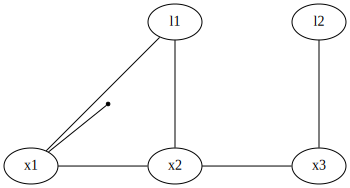

In [3]:
nonlinear_graph, truth, graph_keys = planar_example()
x1, x2, x3, l1, l2 = graph_keys
graph = nonlinear_graph.linearize(truth)
show(nonlinear_graph, truth, binary_edges=True)

The Gaussian marginals around the non-linear solution are shown below:

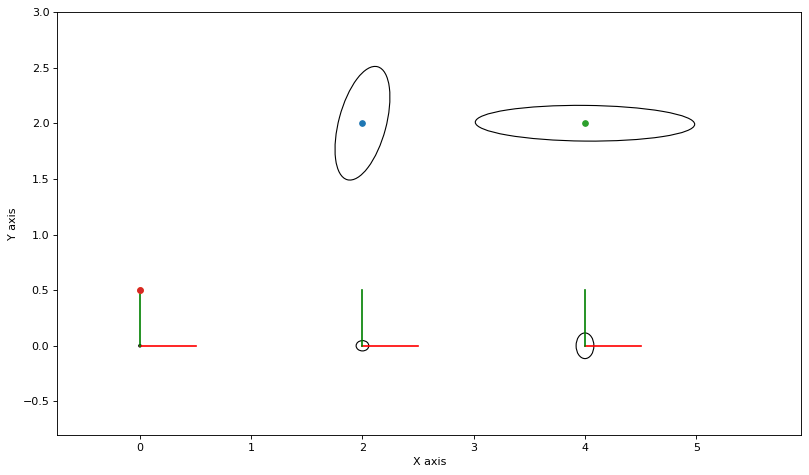

In [4]:
marginals = gtsam.Marginals(graph, truth)
marginals_figure(truth, marginals, graph_keys)

## Cluster Nodes

In the example below we create three clusters: the Markov chain x1-x2-x3 in one cluster, and the two landmarks l1 and l2 each in their own separate cluster. For each we create an initial belief *in the form of a Gaussian Bayes net*:

In [5]:
belief0 = gtsam.GaussianBayesNet()
zero = np.zeros((3,), float)
belief0.push_back(GaussianPrior(x1, zero, 1.5))
belief0.push_back(GaussianPrior(x2, zero, 1.5))
belief0.push_back(GaussianPrior(x3, zero, 1.5))

belief1 = gtsam.GaussianBayesNet()
belief1.push_back(GaussianPrior(l1, zero[:2], 1.5))

belief2 = gtsam.GaussianBayesNet()
belief2.push_back(GaussianPrior(l2, zero[:2], 1.5))

key_sets = [{x1, x2, x3}, {l1}, {l2}]
beliefs = [belief0, belief1, belief2]
node_specs = list(zip(key_sets, beliefs))

Let's then create a set of `Clusters` that each approximate the density of a cluster:

In [6]:
@dataclass(frozen=True)
class Cluster:
    keys: Keys
    belief: gtsam.GaussianBayesNet

variable_nodes = [Cluster(keys, initial_belief)
                for keys, initial_belief in node_specs]

We can't currently update a Bayes tree in python yet, but in C++ we would use a `gtsam.BayesTree` so we can easily get covariances and incrementally update the custer. Soon! 

## Visualizing the Covariances

For now, we can visualize the covariances by converting to a Bayes tree. Note that we add the linear solution to the non-linear values for visualization purposes:

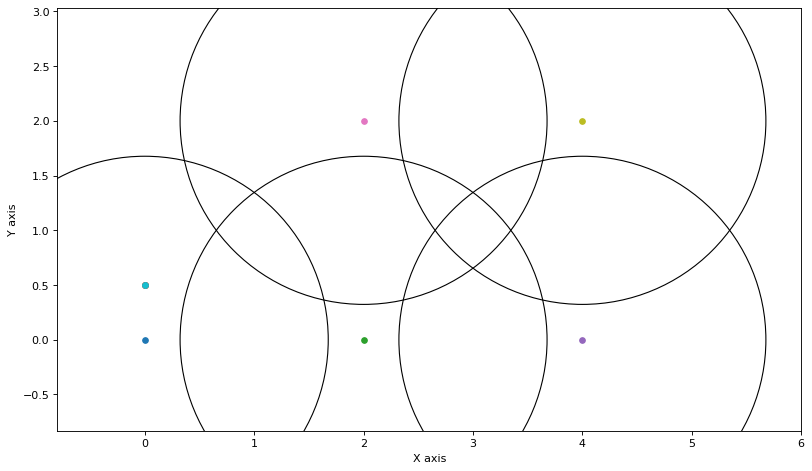

In [7]:
def plot_covariances(variable_nodes):
    """Plot all covariances."""
    graph = gtsam.GaussianFactorGraph()
    for q_j in variable_nodes:
        graph.push_back(q_j.belief)
    bt = graph.eliminateMultifrontal()
    mean = bt.optimize()
    cov = {key: bt.marginalCovariance(key)
           for q_j in variable_nodes for key in q_j.keys}

    plt.figure(0, figsize=(12, 7), dpi=80)
    for key in [x1, x2, x3]:
        gtsam_plot.plot_point2(0, truth.atPose2(key).translation() + mean.at(
            key)[:2], 0.5, bt.marginalCovariance(key))
    for key in [l1, l2]:
        gtsam_plot.plot_point2(0, truth.atPoint2(key) + mean.at(key), 0.5,
                               bt.marginalCovariance(key))

    plt.axis('equal')
    plt.xlim([-0.8, 6])
    plt.ylim([-0.8, 3])


plot_covariances(variable_nodes)

Note that above all beliefs are just uniform Gaussians with a large standard deviation. 

## (Super) Factor Nodes

We also parse the factor graph in "super-factors" that bridge different cluster nodes:

In [8]:
# First figure out which nodes every node is connected to.
factor_indices = defaultdict(set)
for i in range(graph.size()):
    factor = graph.at(i)
    for j, (keys, _) in enumerate(node_specs):
        if keys.intersection(factor.keys()):
            factor_indices[i].add(j)

# Then store based on those index tuples.
factor_nodes = defaultdict(gtsam.GaussianFactorGraph)
for i, edge in factor_indices.items():
    assert len(edge) <= 2, "Invalid interaction between nodes."
    factor_nodes[frozenset(edge)].push_back(graph.at(i))

Every super-factor is really a factor graph. For example, one of the super-factors is intra-cluster:

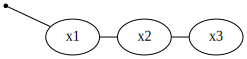

In [9]:
edge0, edge01, edge02 = frozenset({0}), frozenset({0, 1}), frozenset({0, 2})
show(factor_nodes[edge0], hints={'x':0}, binary_edges=True)

And another one is between cluster 0 and 1:

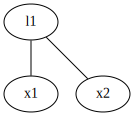

In [10]:
show(factor_nodes[edge01], hints={'x':0, 'l':1}, binary_edges=True)

## Messages

Finally, as in our vanilla LBP implementation, we only have one type of message, from factors (indexed by `frozenset` edges) to clusters (indexed by int). Again, messages are entire factor *graphs* now:

In [11]:
Message = gtsam.GaussianFactorGraph

messages = defaultdict(dict)
for i, factors in factor_nodes.items():
    if len(i) == 1:
        j, *others = i
        messages[j][i] = factors
        continue
    for j in i:
        messages[j][i] = Message()

We initialized the messages $m_{i->j}$ above to empty, except the ones that correspond to unary "factors". There is only one here, which is exactly the intra-cluster factor graph from above:

In [12]:
for j, messages_j in messages.items():
    for i, message_ij in messages_j.items():
        print(f"F_{list(i)} -> X_{j}: size = {message_ij.size()}")

F_[0] -> X_0: size = 3
F_[0, 1] -> X_0: size = 0
F_[0, 2] -> X_0: size = 0
F_[0, 1] -> X_1: size = 0
F_[0, 2] -> X_2: size = 0


## Cluster Belief Propagation

With these three data structures in hand, the code to update the belief of one cluster is easy: just add all "message" factor graphs to a big graph, and then eliminate:

In [13]:
def update_node(j: int):
    """Update cluster j."""
    graph = gtsam.GaussianFactorGraph()
    for message in messages[j].values():
        for i in range(message.size()):
            graph.push_back(message.at(i))

    # Eliminate into Bayes net.
    new_belief = graph.eliminateSequential(gtsam.Ordering.OrderingType.NATURAL)

    variable_nodes[j] = Cluster(variable_nodes[j].keys, new_belief)

For example, updating cluster 0 we get an updated Bayes net on the Markov chain x1-x2-x3, which we show below as a Bayes net (it was eliminated in the x1,x2,x3 order, which is why the past is conditioned on the present), and below that we show the updated covariances:

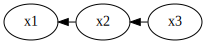

In [14]:
update_node(0)
show(variable_nodes[0].belief, hints={'x':0})

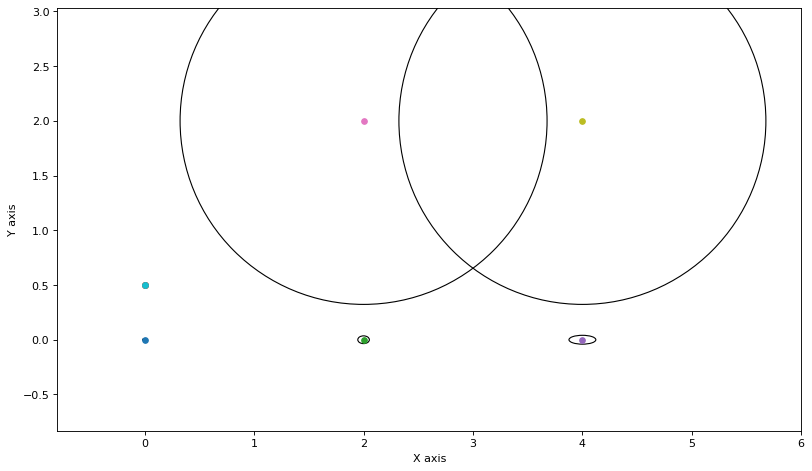

In [15]:
plot_covariances(variable_nodes)

Above we see that the Markov chain has been updated in one fell swoop, and has the correct covariance structure. However, we did not use all information: we should have updated the messages using the other cluster's beliefs first. Let's correct that now.

Calculating a new messages $m_{i\rightarrow j}$ takes the super-factor and adds the belief of the cluster "on the other side" to it, *minus* the messages that was sent to that other cluster:

In [16]:
def calculate_new_message(factors: gtsam.GaussianFactorGraph,
                          keys: Keys, downdated_belief: gtsam.GaussianFactorGraph):
    """Calculate message from factors and belief for sending node."""
    graph = gtsam.GaussianFactorGraph()
    graph.push_back(downdated_belief)
    graph.push_back(factors)
    ordering = gtsam.Ordering()
    for key in keys:
        ordering.push_back(key)
    _, remaining = graph.eliminatePartialSequential(ordering)
    return remaining

With that, we can write our final iteration code:

In [17]:
def update_messages_and_node(j: int):
    """Update messages into cluster j and calculate belief q(X_j)."""
    for edge in messages[j].keys():
        if len(edge) == 2:  # only update binary messages
            j1, j2 = edge
            k = j2 if j1 == j else j1
            other_cluster = variable_nodes[k]
            downdated_belief = gtsam.GaussianFactorGraph()
            downdated_belief.push_back(other_cluster.belief)
            message_to_subtract = messages[k][edge]
            for i in range(message_to_subtract.size()):
                downdated_belief.push_back(message_to_subtract.at(i).negate())
            messages[j][edge] = calculate_new_message(factor_nodes[edge],
                                                      other_cluster.keys,
                                                      downdated_belief)
    update_node(j)

Note that above we down-date the belief for the "other node" before eliminating the variables associated with it. Otherwise we are double-counting information.

## Running Cluster-BP

Below we run this to convergence, which is very fast.

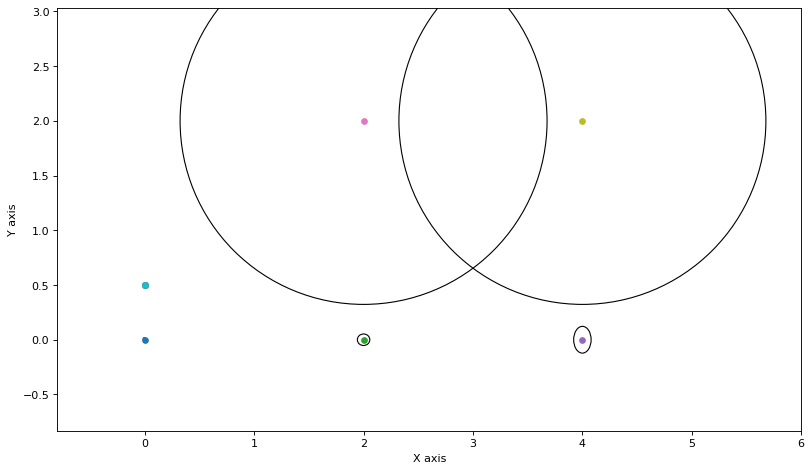

In [18]:
update_messages_and_node(0)
plot_covariances(variable_nodes)

TODO(frank): not sure why uncertainty can be *larger*: we should have more information now.

We update the two other clusters as well:

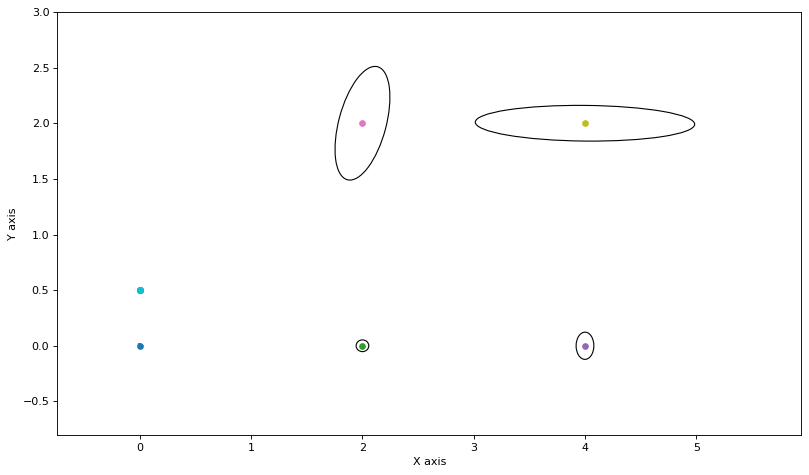

In [19]:
for j in [1,2]:
    update_messages_and_node(j)
plot_covariances(variable_nodes)

As you can see, these are remarkably close, after *one* round-robin iteration. Doing a few more rounds does not make a difference, and when overlaid on the *true* covariances you can hardly see the difference:

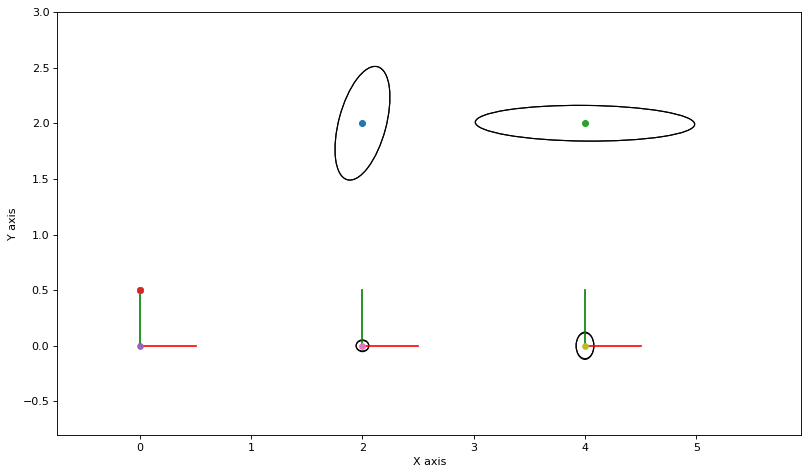

In [20]:
for round in range(5):
    for j in range(3):
        update_messages_and_node(j)
marginals_figure(truth, marginals, graph_keys)
plot_covariances(variable_nodes)

## Different Initial Beliefs

Of course, we started from beliefs that already had the mean correct. But, We get a more interesting animation when we start different points and pretend to be rather confident:

In [21]:
rng = np.random.default_rng(42)
new_belief0 = gtsam.GaussianBayesNet()
minmax = -3.0, 3.0
new_belief0.push_back(GaussianPrior(x1, rng.uniform(*minmax, size=(3,)), 0.1))
new_belief0.push_back(GaussianPrior(x2, rng.uniform(*minmax, size=(3,)), 0.1))
new_belief0.push_back(GaussianPrior(x3, rng.uniform(*minmax, size=(3,)), 0.1))

new_belief1 = gtsam.GaussianBayesNet()
new_belief1.push_back(GaussianPrior(l1, rng.uniform(*minmax, size=(2,)), 0.1))

new_belief2 = gtsam.GaussianBayesNet()
new_belief2.push_back(GaussianPrior(l2, rng.uniform(*minmax, size=(2,)), 0.1))

key_sets = [{x1, x2, x3}, {l1}, {l2}]
new_beliefs = [new_belief0, new_belief1, new_belief2]

new_node_specs = list(zip(key_sets, new_beliefs))
variable_nodes = [Cluster(keys, initial_belief)
                  for keys, initial_belief in new_node_specs]
messages = defaultdict(dict)
for i, factors in factor_nodes.items():
    if len(i) == 1:
        j, *others = i
        messages[j][i] = factors
        continue
    for j in i:
        messages[j][i] = Message()

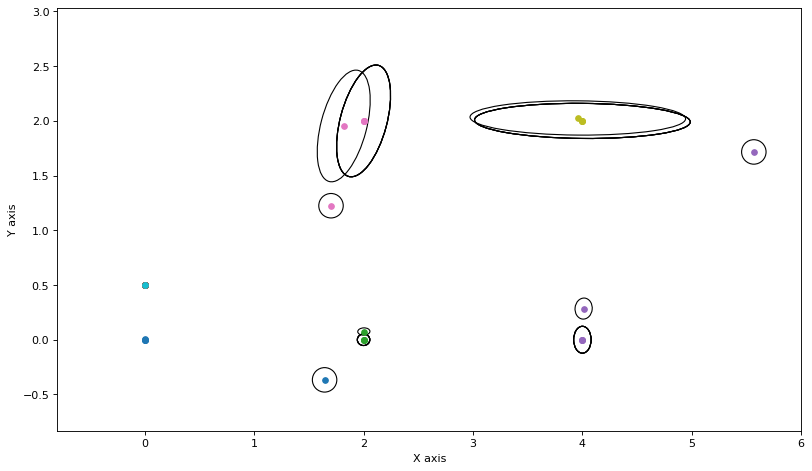

In [22]:
# marginals_figure(truth, marginals, graph_keys)
plot_covariances(variable_nodes)
for round in range(5):
    for j in range(3):
        update_messages_and_node(j)
    plot_covariances(variable_nodes)

Still, for this small graph we converge rather fast.

## Summary

A cluster-based belief propagation approach is still a "mean-field" approximation, but on clusters rather than individual variables. We recover "vanilla" BP if make the clusters contain only one variable, but note that even then these variables are multivariate. Finally, if we use *one* cluster, because we call sparse factorization (`eliminateSequential`!), we converge to the *true* posterior density.

We'll do a larger example in a non-linear SLAM notebook.